In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [2]:
! pip install pyet swifter

In [16]:
import pandas as pd
import pyarrow
import pyet
import math
import datetime
import swifter
import numpy as np
import glob
import os
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
prism_data_daily = pd.read_parquet('/content/drive/MyDrive/EC_Tower/merged_prism_data_par_for_ameri_stations.parquet', engine='pyarrow')


In [5]:
# convert lat to radian
prism_data_daily["latitude_in_radian"] = list(map(math.radians, prism_data_daily["latitude"]))

prism_data_daily['time'] = pd.to_datetime(prism_data_daily['date'],format= "%Y-%m-%d" )

prism_data_daily.set_index('time', inplace=True)
prism_data_daily

,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,tmin,tmax,latitude,longitude,Site_ID,General_classification,Elevation,Energy_balance,Land_cover_details,Land_cover_type,latitude_in_radian
time,,,,,,,,,,,,,,,,,,,,
2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,4.565,6.442,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,4.836,7.053,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,4.656,7.567,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,0.441,9.665,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,0.316,8.929,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,6.817,16.126,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726
2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,4.567,14.088,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726
2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,4.429,13.631,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726


In [6]:
# Solar Constant [ MJ m-2 min-1]
SOLAR_CONSTANT = 0.0820

def standard_date_to_Julian_day (
    standard_date_in_gregorian : str
    ) -> int:

    """
    Description
    -----------
    calculate Julian Day with standard date
    Ref:https://rafatieppo.github.io/post/2018_12_01_juliandate/
    ----------

    standard_date_in_gregorian : str
        Date with the specified standard

    Returns
    -------
    Julian Day : int
        Number of days of the year taking into account the leap year
    """

    fmt='%Y-%m-%d'
    sdtdate = datetime.datetime.strptime(standard_date_in_gregorian, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday

    return(jdate)


def inverse_relative_distance_earth_sun(
    julian_date: int
) -> float:

    """
    Description
    -----------
    calculate Inverse Relative Distance Earth Sun With Julian Date - eq 23 FAO56
    ----------


    Julian Day : int
        Number of days of the year taking into account the leap year

    Returns
    -------
    inverse_relative_distance_earth_sun : float
        inverse relative distance earth sun in Radian
    """

    return 1 + (0.033 * np.cos((2 * np.pi * julian_date)/365))

def solar_declination(
    julian_date: int
) -> float:

    """
    Description
    -----------
    calculate Solar Declination With Julian Date - eq 24 FAO56
    ----------

    julian_date : int
        Number of days of the year taking into account the leap year

    Returns
    -------
    solar_declination : float
        solar_declination in Radian
    """

    return 0.409 * np.sin(((2 * np.pi * julian_date) / 365) - 1.39)

def sunset_hour_angle(
    latitude : float,
    solar_declination : float
) -> float:

    """
    Description
    -----------
    calculate Sunset Hour Angle With Latitude and Solar Declination - eq 25 FAO56
    ----------

    latitude: float
        latitude in Radian
    solar_declination : float
        solar_declination in Radian

    Returns
    -------
    sunset_hour_angle : float
        sunset hour angle in Radian
    """

    return np.arccos(-np.tan(latitude) * np.tan(solar_declination))

def extraterrestrial_radiation(
    inverse_relative_distance_earth_sun : float,
    sunset_hour_angle : float,
    latitude : float,
    solar_declination : float
) -> float:

    """
    Description
    -----------
    calculate Extraterrestrial Radiation - eq 28 FAO56
    ----------

    inverse_relative_distance_earth_sun : float
        inverse relative distance earth sun in Radian
    sunset_hour_angle : float
        sunset hour angle in Radian
    latitude: float
        latitude in Radian
    solar_declination : float
        solar_declination in Radian

    Returns
    -------
    extraterrestrial_radiation : float
            extraterrestrial radiation in MJ/m**2/day
    """

    temp_1 = ((24 * 60 )/ np.pi) * SOLAR_CONSTANT * inverse_relative_distance_earth_sun

    temp_2 = sunset_hour_angle * np.sin(latitude) * np.sin(solar_declination)

    temp_3 = np.cos(latitude)* np.cos(solar_declination) * np.sin(sunset_hour_angle)

    return temp_1 * (temp_2 + temp_3)

def solar_or_Short_wave_Radiation_Hargreaves(
    extraterrestrial_radiation : float,
    tmax : float,
    tmin : float,
    Adjustment_coefficient_or_K_RS : float
)-> float:

    """
    Description
    -----------
    calculate Solar or shortwave radiation with max and min Tempreture - eq 50 FAO56
    ----------

    extraterrestrial_radiation : float
        extraterrestrial radiation in MJ/m**2/day
    tmax : float
        Maximum Temperature in celsius
    tmin : float
        Minimum Temperature in celsius
    Adjustment_coefficient_or_K_RS : float
        Adjustment coefficient in C**-0.5 -- between 0.16 to 0.19
            for interior locations, where land mass dominates and air masses are not strongly
            influenced by a large water body, kRs ≅ 0.16;
            for coastal locations, situated on or adjacent to the coast of a large land mass and where
            air masses are influenced by a nearby water body, kRs ≅ 0.19

    Returns
    -------
    Solar or shortwave radiation : float
        Solar or shortwave radiation in MJ/m**2/day
    """
    temp_1 = extraterrestrial_radiation


    return Adjustment_coefficient_or_K_RS * np.sqrt(tmax - tmin) * temp_1

In [7]:
Adjustment_coefficient_or_K_RS = 0.175

# array_Date = prism_data_daily.date.to_numpy()

# array_latitude = prism_data_daily.latitude_in_radian.to_numpy()

# array_tmin = prism_data_daily["tmin"].to_numpy()

# array_tmax = prism_data_daily["tmax"].to_numpy()


# julian_day = np.vectorize(standard_date_to_Julian_day)(array_Date)
# dr = np.vectorize(inverse_relative_distance_earth_sun)(julian_day)

# delta = np.vectorize(solar_declination)(julian_day)

# omega_s = np.vectorize(sunset_hour_angle)(array_latitude, delta)

# ra = np.vectorize(extraterrestrial_radiation)(dr, omega_s, array_latitude, delta)

# rs = np.vectorize(solar_or_Short_wave_Radiation_Hargreaves)(ra, array_tmax, array_tmin, Adjustment_coefficient_or_K_RS)



prism_data_daily['julian_day'] = prism_data_daily.apply(lambda row: standard_date_to_Julian_day(row['date']), axis=1)
prism_data_daily['dr'] = prism_data_daily.apply(lambda row: inverse_relative_distance_earth_sun(row['julian_day']), axis=1)
prism_data_daily['delta'] = prism_data_daily.apply(lambda row: solar_declination(row['julian_day']), axis=1)
prism_data_daily['omega_s'] = prism_data_daily.apply(lambda row: sunset_hour_angle(row['latitude_in_radian'], row["delta"]), axis=1)
prism_data_daily['ra'] = prism_data_daily.apply(lambda row: extraterrestrial_radiation(row['dr'], row["omega_s"], row["latitude_in_radian"], row["delta"]), axis=1)
prism_data_daily['rs'] = prism_data_daily.apply(lambda row: solar_or_Short_wave_Radiation_Hargreaves(row['ra'], row["tmax"], row["tmin"], Adjustment_coefficient_or_K_RS), axis=1)

# Append each array as a new column
# prism_data_daily['julian_day'] = julian_day
# prism_data_daily['dr'] = dr
# prism_data_daily['delta'] = delta
# prism_data_daily['omega_s'] = omega_s
# prism_data_daily['ra'] = ra
# prism_data_daily['rs'] = rs
prism_data_daily

,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,tmin,...,Energy_balance,Land_cover_details,Land_cover_type,latitude_in_radian,julian_day,dr,delta,omega_s,ra,rs
time,,,,,,,,,,,,,,,,,,,,,
2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,4.565,...,1.00,Peach,Orchards,0.636324,366,1.032995,-0.401008,1.252175,16.025685,3.842260
2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,4.836,...,1.00,Peach,Orchards,0.636324,1,1.032995,-0.401008,1.252175,16.025685,4.175779
2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,4.656,...,1.00,Peach,Orchards,0.636324,2,1.032980,-0.399564,1.253500,16.080602,4.801329
2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,0.441,...,1.00,Peach,Orchards,0.636324,3,1.032956,-0.398001,1.254930,16.139901,8.578247
2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,0.316,...,1.00,Peach,Orchards,0.636324,4,1.032922,-0.396320,1.256466,16.203566,8.321965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,6.817,...,0.86,Brackish tidal marsh,Wetlands,0.666726,361,1.032922,-0.406440,1.225258,14.737636,7.868961
2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,4.567,...,0.86,Brackish tidal marsh,Wetlands,0.666726,362,1.032956,-0.405594,1.226097,14.770615,7.975867
2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,4.429,...,0.86,Brackish tidal marsh,Wetlands,0.666726,363,1.032980,-0.404627,1.227054,14.808078,7.861001


In [8]:
# prism_data_daily["blaney_criddle"] = pyet.blaney_criddle(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )

# prism_data_daily["hamon"] = pyet.hamon(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )

prism_data_daily["oudin"] = pyet.oudin(
    tmean = prism_data_daily["tmean"],
    lat = prism_data_daily["latitude_in_radian"]
)

prism_data_daily["hargreaves"] = pyet.hargreaves(
    tmean = prism_data_daily["tmean"],
    tmax = prism_data_daily["tmax"],
    tmin = prism_data_daily["tmin"],
    lat = prism_data_daily["latitude_in_radian"]
)

prism_data_daily["abtew"] = pyet.abtew(
    tmean = prism_data_daily["tmean"],
    rs = prism_data_daily["rs"]
)


prism_data_daily["mcguinness_bordne"] = pyet.mcguinness_bordne(
    tmean = prism_data_daily["tmean"],
    lat = prism_data_daily["latitude_in_radian"]
)

# prism_data_daily["jensen_haise"] = pyet.jensen_haise(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )
prism_data_daily = prism_data_daily.reset_index()

In [9]:
# Specify the directory path and file pattern

file_path = '/content/drive/MyDrive/EC_Tower/stations/*.csv'
csv_files = glob.glob(file_path)

dfs = []

for file in csv_files:

    ts_data = pd.read_csv(file)

    ts_data["Site_ID"] = file.removesuffix("_daily_data.csv")[41:]

    dfs.append(ts_data)

merged_df = pd.concat(dfs, ignore_index=True)
merged_df



,date,rh,H,sw_in,t_dew,vp,theta_1,lw_out,LE,wd,...,ET_gap,ET_fill_val,Site_ID,H_qc_flag,Rn_qc_flag,LE_qc_flag,t_avg_qc_flag,vpd_qc_flag,G_qc_flag,ppt
0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20138,2018-05-31,58.591875,74.299147,346.442861,11.252931,1.361338,26.386760,404.013732,60.627478,242.604626,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20139,2018-06-01,54.740417,57.072189,354.218242,12.342688,1.462196,26.324656,420.252554,75.335373,282.614125,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20140,2018-06-02,45.873125,34.105066,356.110903,12.915099,1.533126,26.316750,438.610560,109.118007,238.779884,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20141,2018-06-03,47.508958,15.475881,353.838460,13.621733,1.604567,26.276646,443.144378,122.170050,225.033641,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:



# Merge the DataFrames
result = pd.merge(prism_data_daily, merged_df[['date', 'Site_ID', 'ET_fill']],
                  on=['date', 'Site_ID'],
                  how='left')

result

,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,dr,delta,omega_s,ra,rs,oudin,hargreaves,abtew,mcguinness_bordne,ET_fill
0,2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,...,1.032995,-0.401008,1.252175,16.025685,3.842260,0.676516,0.472973,0.818486,0.994479,NaN
1,2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,...,1.032995,-0.401008,1.252175,16.025685,4.175779,0.705217,0.523976,0.889905,1.036669,NaN
2,2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,...,1.032980,-0.399564,1.253500,16.080602,4.801329,0.718546,0.606803,1.023379,1.056262,NaN
3,2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,...,1.032956,-0.398001,1.254930,16.139901,8.578247,0.651802,1.035083,1.826573,0.958149,NaN
4,2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,...,1.032922,-0.396320,1.256466,16.203566,8.321965,0.626125,0.984862,1.771280,0.920404,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56974,2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,...,1.032922,-0.406440,1.225258,14.737636,7.868961,0.981236,1.223674,1.685809,1.442417,NaN
56975,2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,...,1.032956,-0.405594,1.226097,14.770615,7.975867,0.853682,1.147109,1.705223,1.254913,NaN
56976,2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,...,1.032980,-0.404627,1.227054,14.808078,7.861001,0.837833,1.117869,1.680189,1.231615,NaN
56977,2020-12-29,12_20201230,2020-12-29,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",-1.101,9.277900,15.402,0.592,...,1.032995,-0.403540,1.228128,14.850017,10.391113,0.855260,1.491673,2.221492,1.257232,NaN


In [11]:
def budyko(pet, p):
    # from Budyko 1958
    # p,pet = X
    if p == 0:
        x = 0
    else:
        # x = (1 + (0.5 * (pet / p)** (-1.5)))**(-1)
        x = math.sqrt(((pet/p)*math.tanh(p/pet))*(1-math.exp(-pet/p)))
    return x


def aet(ratio, p):
  return ratio * p

In [12]:
# array_p = result["ppt"].to_numpy()

# array_pet_oudin = result["oudin"].to_numpy()
# array_pet_hargreaves = result["hargreaves"].to_numpy()
# array_pet_abtew = result["abtew"].to_numpy()
# array_pet_mcguinness_bordne = result["mcguinness_bordne"].to_numpy()



# ratio_budyko_oudin = np.vectorize(budyko)(array_pet_oudin, array_p)
# aet_budyko_oudin = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_oudin, p = array_p)

# ratio_budyko_hargreaves = np.vectorize(budyko)(array_pet_hargreaves, array_p)
# aet_budyko_hargreaves = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_hargreaves, p = array_p)

# ratio_budyko_abtew = np.vectorize(budyko)(array_pet_abtew, array_p)
# aet_budyko_abtew = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_abtew, p = array_p)

# ratio_budyko__mcguinness_bordne = np.vectorize(budyko)(array_pet_mcguinness_bordne, array_p)
# aet_budyko__mcguinness_bordne = np.vectorize(lambda r, p: r * p)(r = ratio_budyko__mcguinness_bordne, p = array_p)



result['ratio_budyko_oudin'] = result.apply(lambda row: budyko(row['oudin'], row["ppt"]), axis=1)

result['aet_budyko_oudin'] = result.apply(lambda row: aet(row['ratio_budyko_oudin'], row["ppt"]), axis=1)


result['ratio_budyko_hargreaves'] = result.apply(lambda row: budyko(row['hargreaves'], row["ppt"]), axis=1)

result['aet_budyko_hargreaves'] = result.apply(lambda row: aet(row['ratio_budyko_hargreaves'], row["ppt"]), axis=1)


result['ratio_budyko_abtew'] = result.apply(lambda row: budyko(row['abtew'], row["ppt"]), axis=1)

result['aet_budyko_abtew'] = result.apply(lambda row: aet(row['ratio_budyko_abtew'], row["ppt"]), axis=1)


result['ratio_budyko_mcguinness_bordne'] = result.apply(lambda row: budyko(row['mcguinness_bordne'], row["ppt"]), axis=1)

result['aet_budyko_mcguinness_bordne'] = result.apply(lambda row: aet(row['ratio_budyko_mcguinness_bordne'], row["ppt"]), axis=1)


result

# result['aet_budyko_oudin'] = aet_budyko_oudin
# result['aet_budyko_hargreaves'] = aet_budyko_hargreaves
# result['aet_budyko_abtew'] = aet_budyko_abtew
# result['aet_budyko__mcguinness_bordne'] = aet_budyko__mcguinness_bordne


,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,mcguinness_bordne,ET_fill,ratio_budyko_oudin,aet_budyko_oudin,ratio_budyko_hargreaves,aet_budyko_hargreaves,ratio_budyko_abtew,aet_budyko_abtew,ratio_budyko_mcguinness_bordne,aet_budyko_mcguinness_bordne
0,2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,...,0.994479,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,...,1.036669,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,...,1.056262,NaN,0.233268,0.676011,0.198876,0.576341,0.323011,0.936085,0.332279,0.962946
3,2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,...,0.958149,NaN,0.951844,0.217020,0.986726,0.224974,0.997250,0.227373,0.983290,0.224190
4,2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,...,0.920404,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56974,2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,...,1.442417,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56975,2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,...,1.254913,NaN,0.558132,0.684828,0.669477,0.821448,0.802162,0.984252,0.701850,0.861170
56976,2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,...,1.231615,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56977,2020-12-29,12_20201230,2020-12-29,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",-1.101,9.277900,15.402,0.592,...,1.257232,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# Assuming your DataFrame is named 'df' and the two columns are 'actual' and 'predicted'
def calculate_metrics(df, actual_col, predicted_col):
    actual = df[actual_col]
    predicted = df[predicted_col]

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    nse = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

    nrmse = rmse / (np.max(actual) - np.min(actual))

    return rmse, nse, nrmse

In [14]:
filtered_df = result[result['ET_fill'].apply(lambda x: isinstance(x, float) and not np.isnan(x))]

filtered_df = filtered_df[filtered_df['ratio_budyko_hargreaves'].apply(lambda x: isinstance(x, float) and not np.isnan(x))]

filtered_df = filtered_df[filtered_df['ratio_budyko_hargreaves'].apply(lambda x: isinstance(x, float) and x != 0)]

filtered_df = filtered_df[filtered_df['point_id'].apply(lambda x: x ==1)]

# filtered_df = filtered_df[filtered_df['ppt'].apply(lambda x: isinstance(x, float) and x != 0)]



rmse, nse, nrmse = calculate_metrics(filtered_df, 'ET_fill', 'aet_budyko_hargreaves')


print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")
print(f"NRMSE: {nrmse:.4f}")


RMSE: 1.3225
NSE: 0.0092
NRMSE: 0.1917


In [25]:
def rmse(df, simulation, observation):
    """
    Root mean square error function
    Args: df (pandas.DataFrame): pandas dataframe with 'simulation' and 'observation' columns
    Returns: out (float): calculated RMSE value
    """

    df = df.dropna()
    sim = df[f"{simulation}"]
    obs = df[f"{observation}"]
    out = np.sqrt(np.nanmean((sim-obs)**2))
    return out

def nse(df, simulation, observation):
    """
    Nash-sutcliffe model efficiency coefficient function
    Args: df (pandas.DataFrame): pandas dataframe with 'simulation' and 'observation' columns
    Returns: out (float): calculated NSE value
    """

    df = df.dropna()
    sim = df[f"{simulation}"]
    obs = df[f"{observation}"]
    out = 1 - (np.nansum((sim-obs)**2)/np.nansum((obs-np.nanmean(obs))**2))
    return out

def r(df, simulation, observation):
    """
    Correlation coefficient function
    Args: df (pandas.DataFrame): pandas dataframe with 'simulation' and 'observation' columns
    Returns: out (float): calculated correlation coefficient value
    """

    df = df.dropna()
    sim = df[f"{simulation}"]
    obs = df[f"{observation}"]
    out = stats.pearsonr(sim,obs)[0]
    return out



In [26]:

filtered_df['year_month'] = filtered_df['time'].dt.strftime('%Y-%m')


monthly_data = filtered_df.groupby(['Site_ID', 'year_month']).agg({
    'aet_budyko_hargreaves' : 'sum',
    'ET_fill' : 'sum'
}).reset_index()

monthly_data




,Site_ID,year_month,aet_budyko_hargreaves,ET_fill
0,MB_Pch,2012-04,14.381213,16.612855
1,MB_Pch,2012-05,0.548879,4.960049
2,MB_Pch,2012-10,3.158694,5.240487
3,MB_Pch,2012-11,7.669248,13.390227
4,MB_Pch,2012-12,10.648654,8.780199
5,MB_Pch,2013-01,4.586698,4.774126
6,MB_Pch,2013-02,3.991779,2.065646
7,MB_Pch,2013-03,6.843364,5.753576
8,MB_Pch,2013-04,2.148366,1.566705
9,MB_Pch,2013-05,3.699826,10.394407


In [28]:
rmse_m, nse_m, nrmse_m = calculate_metrics(monthly_data, 'ET_fill', 'aet_budyko_hargreaves')

r_m = r(monthly_data, "aet_budyko_hargreaves", "ET_fill")


print(f"RMSE: {rmse_m:.4f}")
print(f"NSE: {nse_m:.4f}")
print(f"NRMSE: {nrmse_m:.4f}")
print(f"R2: {r_m**2:.4f}")

RMSE: 3.4268
NSE: 0.4004
NRMSE: 0.1834
R2: 0.4973


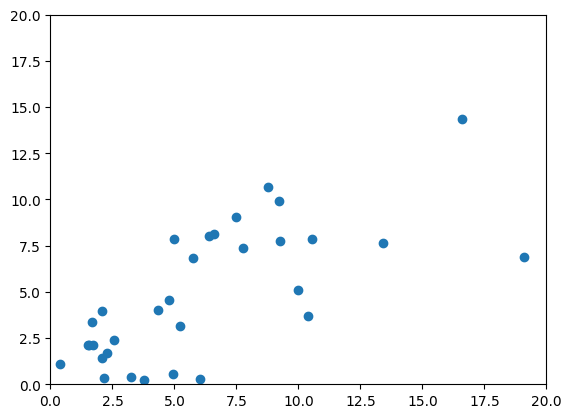

In [33]:
plt.scatter(monthly_data["ET_fill"], monthly_data["aet_budyko_hargreaves"])
# set axes range
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

In [29]:
filtered_df["year"] = filtered_df['time'].dt.year

yearly_data = filtered_df.groupby(['Site_ID', 'year']).agg({
    'aet_budyko_hargreaves' : 'sum',
    'ET_fill' : 'sum'
}).reset_index()

yearly_data

,Site_ID,year,aet_budyko_hargreaves,ET_fill
0,MB_Pch,2012,36.406687,48.983817
1,MB_Pch,2013,26.018635,32.652802
2,MB_Pch,2014,37.617532,38.468999
3,MB_Pch,2015,54.990344,76.456485


In [30]:
rmse_y, nse_y, nrmse_y = calculate_metrics(yearly_data, 'ET_fill', 'aet_budyko_hargreaves')

r_y = r(yearly_data, "aet_budyko_hargreaves", "ET_fill")


print(f"RMSE: {rmse_y:.4f}")
print(f"NSE: {nse_y:.4f}")
print(f"NRMSE: {nrmse_y:.4f}")
print(f"R2: {r_y**2:.4f}")

RMSE: 12.8813
NSE: 0.4136
NRMSE: 0.2941
R2: 0.9058


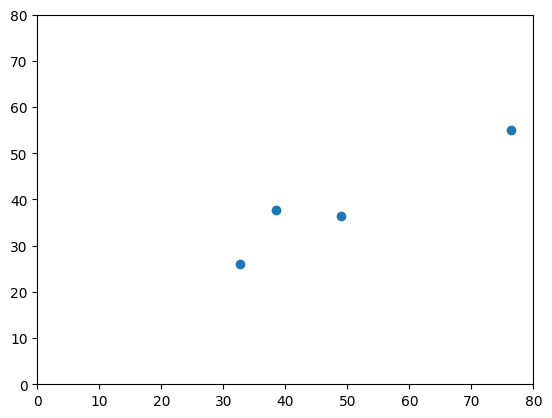

In [35]:
plt.scatter(yearly_data["ET_fill"], yearly_data["aet_budyko_hargreaves"])
# set axes range
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()